# Modelo XGBoost

### Autores: Matías Corredoira de Soto y Pablo Revuelta Stobbs

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import xgboost as xgb
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, recall_score, roc_auc_score, plot_precision_recall_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
import scikitplot as skplt

In [3]:
pathfile1 = '../data/loans_ind_clean.csv'

In [4]:
loans_ind = pd.read_csv(pathfile1, engine = 'python')
loans_ind.head()

,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,title,...,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg
0,36.0,359.26,A,6.0,OWN,153000.0,Not Verified,1.0,credit_card,Credit card refinancing,...,20,2,95.7,11.1,1,528172,100865,28100,120572,722.0
1,36.0,285.70,E,2.0,RENT,50000.0,Source Verified,1.0,debt_consolidation,Debt consolidation,...,4,0,80.0,100.0,0,7600,5588,3600,4000,687.0
2,36.0,232.79,A,7.0,MORTGAGE,110000.0,Not Verified,1.0,debt_consolidation,Debt consolidation,...,19,3,100.0,8.3,0,350617,45955,83700,32239,712.0
3,60.0,243.29,C,7.0,RENT,51979.0,Source Verified,1.0,debt_consolidation,Debt consolidation,...,15,3,100.0,0.0,2,34200,10956,18800,5500,692.0
4,36.0,492.34,C,7.0,MORTGAGE,75000.0,Verified,1.0,debt_consolidation,Debt consolidation,...,4,3,90.0,100.0,0,170591,27684,3000,30321,687.0


In [5]:
y = loans_ind['loan_status']
x = loans_ind.drop('loan_status', axis = 1)
x_list = list(x.columns)

In [6]:
numeric_transformer_0 = Pipeline(steps = [
    ('imputer_0', SimpleImputer(strategy = 'constant')),
    ('escalar', StandardScaler())
])

numeric_transformer_median = Pipeline(steps = [
    ('imputer_median', SimpleImputer(strategy = 'median')),
    ('escalar1', StandardScaler())
])

categoric_transformer  = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'sin_info')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')) # mirar esto de handle_unknowns
])

In [7]:
numeric_features_0 = x.loc[:, ['bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'emp_length', 'term', 'installment', 'annual_inc', 'inq_last_6mths',
                                      'mths_since_last_delinq', 'open_acc', 'revol_bal', 'total_acc', 'tot_cur_bal', 'acc_open_past_24mths',
                                       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
                                      'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_inq', 'num_actv_rev_tl',
                                       'num_sats', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
                                      'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'fico_avg']].columns

numeric_features_median = x.loc[:, ['percent_bc_gt_75',
                                            'bc_util',
                                            'avg_cur_bal',
                                            'num_rev_accts',
                                            'dti']].columns


categoric_features = x.select_dtypes(include = ['object']).columns

In [8]:
preprocessor = ColumnTransformer(
        transformers = [
            ('num_0', numeric_transformer_0, numeric_features_0),
            ('num_median', numeric_transformer_median, numeric_features_median),
            ('cat', categoric_transformer, categoric_features)
        ]
)

In [42]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(x,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42)


In [10]:
test_y.value_counts()

1.0    85984
0.0    29152
Name: loan_status, dtype: int64

In [68]:
train_y.value_counts()

1.0    258623
0.0     86782
Name: loan_status, dtype: int64

In [11]:
xgboost = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', xgb.XGBClassifier(random_state = 123))
                    ])

In [12]:
%%time

xgboost.fit(train_x, train_y)

Wall time: 2min 19s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_0',
                                                  Pipeline(steps=[('imputer_0',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('escalar',
                                                                   StandardScaler())]),
                                                  Index(['bc_open_to_buy', 'mths_since_recent_bc', 'revol_util', 'emp_length',
       'term', 'installment', 'annual_inc', 'inq_last_6mths',
       'mths_since_last_delinq', 'open_acc', 'revol_bal', 'total_ac...
                                                  Index(['percent_bc_gt_75', 'bc_util', 'avg_cur_bal', 'num_rev_accts', 'dti'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                 

In [13]:
print("model score: %.3f" % xgboost.score(test_x, test_y))

model score: 0.760


In [43]:
pred_y = xgboost.predict(test_x)

In [15]:
filename = 'model_xgboost.sav'

In [44]:
xgboost.score(test_x, test_y)

0.7598405364091162

In [16]:
pickle.dump(xgboost, open(filename, 'wb'))

# Parametres Tuning

In [54]:
#params = {
#    'classifier__learning_rate' : [0.1, 0.2],
#    'classifier__n_estimators' : [200, 500],
#    'classifier__max_depth' : [3, 5, 7],
#    'classifier__tol' : [0.5],
#    'classifier__random_state' : [123]
#}

In [60]:
#xgboost_gs = GridSearchCV(xgboost,
#                          param_grid = params)

In [61]:
#%%time

#xgboost_gs.fit(train_x, train_y)

KeyboardInterrupt: 

El coste computacional para tunear los hiperparámetros de XGBOOST es demasiado elevado inclusive con un limite de error de 0.5.

In [ ]:
#filename1 = 'model_final_xgboost.sav'
#pickle.dump(xgboost_gs, open(filename1, 'wb'))

# Análisis

In [38]:
xgboost = pickle.load(open('../modelos/model_xgboost.sav', 'rb'))

In [45]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.60      0.15      0.24     29152
         1.0       0.77      0.97      0.86     85984

    accuracy                           0.76    115136
   macro avg       0.69      0.56      0.55    115136
weighted avg       0.73      0.76      0.70    115136



## Matriz de confusión

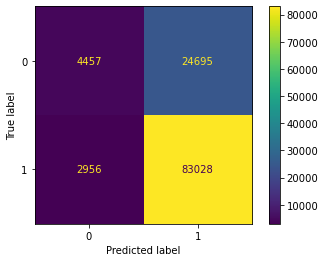

In [48]:
confusion_matrix = confusion_matrix(test_y, pred_y)
ConfusionMatrixDisplay(confusion_matrix).plot()

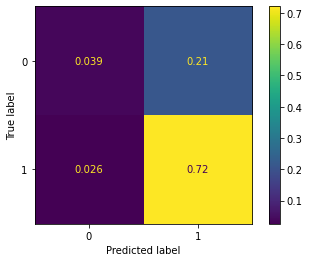

In [36]:
ConfusionMatrixDisplay(confusion_matrix/np.sum(confusion_matrix)).plot()

Observando la matriz de confusión, se observa que el modelo predice muy bien para las observaciones en las que no hay impago en el crédito. Sin embargo, se observa que para las observaciones en las que no se debería entregar el crédito debido a impago, su precisión es muy baja, ya que el modelo los considera como que si que hay que entregarle el crédito cuando no debería ser así.

Esto puede ser debido a que nos encontramos ante una base de datos imbalanceada o debido a que las variables utilizadas para el modelo no son las adecuadas.

Teniendo en cuenta que el porcentaje de observaciones que no tienen impago es del 75 % respecto al total del dataset, se puede considerar que un 25 % de observaciones en las que hay impago debería ser suficiente para poder ejecutar un modelo adecuado.

## Curva ROC

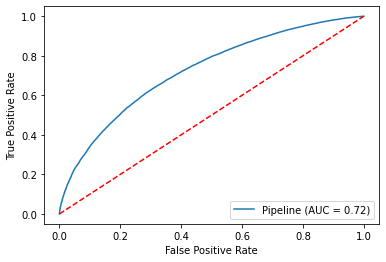

In [29]:
metrics.plot_roc_curve(xgboost, test_x, test_y)
plt.plot([0, 1], [0, 1], 'r--')

## Precision Recall

In [51]:
precision, recall, thresholds = precision_recall_curve(test_y, pred_y)

area = auc(recall, precision)

print('------------ Results for XGBClassifier ---------------')
print('recall_score:', recall_score(test_y, pred_y))
print('roc_auc_score:',roc_auc_score(test_y, pred_y))
print("Area Under P-R Curve: ",area)

------------ __Results for XGBClassifier__ ---------------
recall_score: 0.9656215109787868
roc_auc_score: 0.559254910264366
Area Under P-R Curve:  0.8810250585868571


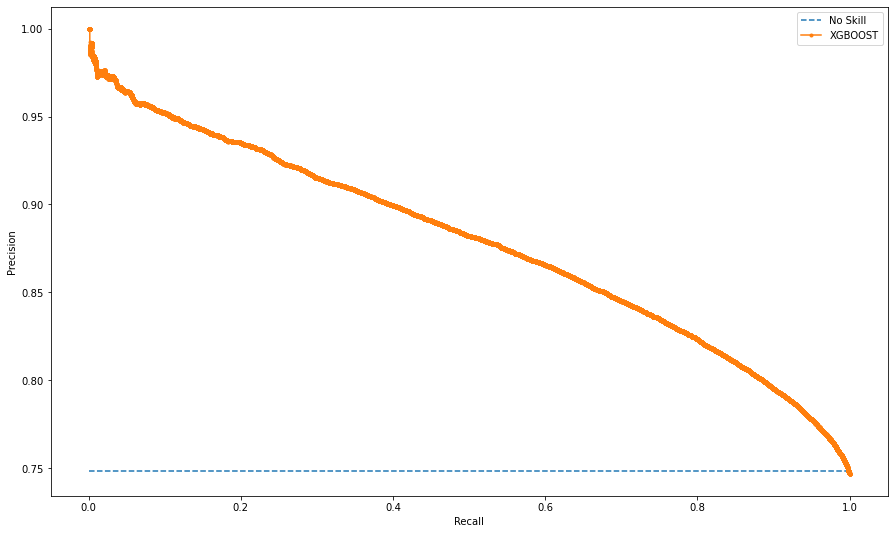

In [23]:
# predict probabilities
yhat = xgboost.predict_proba(test_x)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.figure(figsize=(15,9))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(test_y, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='XGBOOST')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/

Se observa que el recall aumenta en gran medida cuando disminuye en menor proporción la precisión del modelo. Esto indica que el modelo actua de forma adecuada sobre la característica primordial del modelo, que en este caso es la de entregar el crédito, por lo que es de esperar buenos resultados para la misma.

## Gain Curve

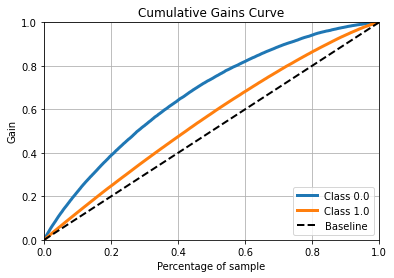

In [27]:
predicted_probabilities = xgboost.predict_proba(test_x)
skplt.metrics.plot_cumulative_gain(test_y, predicted_probabilities)
plt.show()

Se observa que para las observaciones de la clase 0 tiene una utilidad marginal mayor a principio, aproximadamente hasta un 50 % de la muestra, mientras que para la clase 1 no se diferencia mucho de la base.

# Modelo loan joint

In [62]:
pathfile1 = '../data/loans_joint_clean.csv'

In [63]:
loans_joint = pd.read_csv(pathfile1, engine = 'python')
loans_joint.head()

,Unnamed: 0,term,installment,grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,fico_avg
0,0,36.0,486.98,B,3.0,MORTGAGE,115000.0,Not Verified,1.0,car,...,Jul-1995,0.0,2.0,8.0,7.7,0.0,27.0,0.0,0.0,682.0
1,1,36.0,112.83,B,3.0,MORTGAGE,40000.0,Verified,1.0,debt_consolidation,...,Jan-2007,0.0,2.0,18.0,50.0,3.0,20.0,0.0,0.0,672.0
2,2,36.0,285.70,E,1.0,RENT,24000.0,Not Verified,0.0,other,...,Sep-2005,0.0,0.0,23.0,NaN,23.0,2.0,1.0,3.0,662.0
3,3,60.0,437.92,C,5.0,MORTGAGE,55000.0,Source Verified,1.0,home_improvement,...,Jun-2006,2.0,3.0,23.0,42.1,13.0,13.0,0.0,2.0,697.0
4,4,36.0,817.41,B,NaN,MORTGAGE,32000.0,Verified,0.0,credit_card,...,Oct-1997,0.0,2.0,14.0,76.1,2.0,24.0,0.0,0.0,692.0


In [64]:
y_joint = loans_joint['loan_status']
x_joint = loans_joint.drop('loan_status', axis = 1)

In [65]:
numeric_transformer_0_joint = Pipeline(steps = [
    ('imputer_0_joint', SimpleImputer(strategy = 'constant')),
    ('escalar_joint', StandardScaler())
])


categoric_transformer_joint  = Pipeline(steps = [
    ('imputer_joint', SimpleImputer(strategy = 'constant', fill_value = 'sin_info')),
    ('onehot_joint', OneHotEncoder(handle_unknown = 'ignore')) # mirar esto de handle_unknowns
])

In [66]:
numeric_features_0_joint = x_joint.select_dtypes(include=['int64', 'float64']).columns

categoric_features_joint = x_joint.select_dtypes(include = ['object']).columns

In [67]:
preprocessor_joint = ColumnTransformer(
        transformers = [
            ('num_0_joint', numeric_transformer_0_joint, numeric_features_0_joint),
            ('cat_joint', categoric_transformer_joint, categoric_features_joint)
        ]
)

In [68]:
from sklearn.model_selection import train_test_split

train_x_joint, test_x_joint, train_y_joint, test_y_joint = train_test_split(x_joint,
                                                    y_joint,
                                                    test_size = 0.25,
                                                    random_state = 42)

In [69]:
xgboost_joint = Pipeline(steps=[('preprocessor_joint', preprocessor_joint),
                     ('classifier_joint', xgb.XGBClassifier(random_state = 123))
                    ])

In [70]:
%%time

xgboost_joint.fit(train_x_joint, train_y_joint)

Wall time: 469 ms


Pipeline(steps=[('preprocessor_joint',
                 ColumnTransformer(transformers=[('num_0_joint',
                                                  Pipeline(steps=[('imputer_0_joint',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('escalar_joint',
                                                                   StandardScaler())]),
                                                  Index(['Unnamed: 0', 'term', 'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_b...
                                                                                 strategy='constant')),
                                                                  ('onehot_joint',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),


In [71]:
print("model score: %.3f" % xgboost_joint.score(test_x_joint, test_y_joint))

model score: 0.668


In [72]:
filename_joint = 'model_xgboost_joint.sav'

In [73]:
pickle.dump(xgboost_joint, open(filename_joint, 'wb'))

## Referencias
https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python.html

https://datascience.stackexchange.com/questions/16232/in-xgboost-would-we-evaluate-results-with-a-precision-recall-curve-vs-roc